# Estimación de la frecuencia cardiaca utilizando métodos estadísticos.
Las muestras se obtuvieron utilizando una app para obtener imágenes de fotoplestimografía, las cuales, se procesaron para obtener las señales de ellas.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.signal import butter, lfilter, find_peaks, firwin, iirfilter, square, detrend
from scipy.interpolate import interp1d
from scipy import sparse, stats
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from datetime import timedelta

class limpiezaSenal:
    def __init__(self, ventana):
        self.ventana = ventana
        self.ventana_linea_base = []
        self.ceros = []
        self.posMinimos = []
        self.pulsos = []
        self.recta = []
        self.with_gaussian_filter = []
        self.caracteristicas = []

    def Change_Point(self, section_a, section_b, point):
        s = np.concatenate( ( section_a , section_b ) )
        m1 = np.mean( section_a )
        m2 = np.mean( section_b )
        m = np.concatenate(( np.repeat(m1, point, axis=0) , np.repeat(m2, (len(s) - point), axis=0) ), axis=0)
        return s - m
        
    def Cut_Outlayers(self, signal_raw, outlayers):
        sections = []
        i = 0
        j = 1
        a = signal_raw[0:  outlayers.index[0] ] 
        while j < len(outlayers.index):
            b = signal_raw[ (outlayers.index[i] + 1 ) : outlayers.index[j] + 1]
            if b.any():
                a = self.Change_Point(a, b, outlayers.index[i])
            i = j
            j += 1
        b = signal_raw[ (outlayers.index[i] + 1 ) : len(signal_raw) ]
        a = self.Change_Point(a, b, outlayers.index[i])
        return a
        
    def Detect_change_points(self, signal, outlayers):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.vlines(x = outlayers.index, ymin=0, ymax=1, color='red', linestyle='dashed')
        ax2 = ax.twinx()
        ax2.plot(self.ventana,'b')
        plt.show()
        change_signal = self.Cut_Outlayers(signal, outlayers)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(change_signal, 'b')
        plt.show()
        return change_signal

    def Diferencia_Senal(self, senal, interval = 1):
        diff = list()
        for i in range(interval, len(senal)):
            value = senal[i] - senal[i - interval]
            diff.append(value)
        diff.append(0)
        return diff

    def Identificar_Outlayers(self, signal):
        signal = pd.Series(signal)
        treshold = 3
        upper_limit = signal.mean() + treshold *signal.std()
        lower_limit = signal.mean() - treshold *signal.std()
        out = signal[(signal > upper_limit) | (signal < lower_limit)]
        return out
    
    def Remove_Outlayers(self, signal):
        s = signal[(np.abs(stats.zscore(signal)) < 3)]
        return s
        
    def Butterworth_Filters(self, als):
        b, a = butter(3, (0.25, 0.5), 'band', analog=True) 
        senal_filtrada = lfilter(b, a, als) 
        return senal_filtrada

    def Gaussian_Filter(self, b_iir):
        sigma = 5
        window_size = 4
        t = (((window_size - 1)/2)-0.5)/sigma
        return scipy.ndimage.filters.gaussian_filter(b_iir, sigma=sigma, truncate=t) 

    def f(self, args):
        x, y = args
        return (x-a)**2 + (y-b)**2
    
    def Baseline_als_optimized(self, y, lam, p, niter):
        L = len(y)
        D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
        D = lam * D.dot(D.transpose()) 
        w = np.ones(L)
        W = sparse.spdiags(w, 0, L, L)
        for i in range(niter):
            W.setdiag(w)
            Z = W + D
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
        
    def ALS_Filter(self, senal):
        return senal - self.Baseline_als_optimized(senal, 60, 0.001, 10)

    def Remove_bad_signal(self, senal, valley):
        pru = []
        s1 = 0
        s2 = 1
        while s2 < len(valley):
            pru.append(valley[s2] - valley[s1])
            s1 = s2
            s2 += 1
        m = np.mean(pru)
        s1 = 0
        s2 = 1
        new_signal = []
        while s2 < len(valley):
            v = valley[s2] - valley[s1] 
            if (v + 3.5) >= m and  (v - 3.5) <= m:
                conc = senal[valley[s1]:valley[s2] + 1]
                new_signal.append(conc)
            s1 = s2
            s2 += 1
        return new_signal
        
    def Get_peaks(self, senal):
        peaks_bottom = find_peaks(senal * -1 )
        peaks2 = []
        peaks_pos2 = []
        mini = np.amin(senal)
        vally = peaks_bottom[0]
        for pos in peaks_bottom[0]:
            if senal[pos] >= mini and senal[pos] <= mini * -2 : #Condicion que define rango de valles a encontrar.
                peaks_pos2.append(pos)
                peaks2.append(senal[pos])
        new_signal = self.Remove_bad_signal(senal, peaks_pos2)
        
        fig = plt.figure()
        ax = fig.subplots()
        ax.plot(senal)
        ax.scatter(peaks_pos2, peaks2, color = 'b', s = 15, marker = 'D')
        ax.legend()
        ax.grid()
        plt.show()
        return new_signal

    def Get_Pulses(self, picos, senal):
        senales = []
        pik_sig = 1
        pik_act = 0
        pik_pas = 0
        while pik_sig < len(picos):
            pos_pik_act = picos[pik_act]
            valle1 = np.where(senal == np.amin(senal[ pik_pas : pos_pik_act ])) #Obtengo la posicion del valle del proceso
            valle2 = np.where(senal == np.amin(senal[ pos_pik_act : picos[pik_sig] ]))
            senales.append( senal[int(valle1[0]) : int(valle2[0]) ] )
            pik_pas = picos[pik_act]
            pik_act = pik_sig
            pik_sig +=1
        return senales

    def Crear_Grafica_Pulsos(self, p_c_MA):
        x = 0
        count = []
        fig, ax = plt.subplots(1,1)
        for s in p_c_MA: #self.pulsos:
            for d in range(x,x+len(s)):
                count.append(d)
            ax.plot(count, s)
            x += len(s) -1
            count = []
        count = []
        ax.set_title('Pulsos de la señal')
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
        plt.show()

    def Crear_Grafica(self, d1, d2, d3, d4, names):
        fig, ax = plt.subplots(4,1)
        ax[0].plot(d1, 'tab:red')
        ax[0].set_title(names[0])
        ax[1].plot(d2, 'tab:orange')
        ax[1].set_title(names[1])
        ax[2].plot(d3, 'tab:green')
        ax[2].set_title(names[2])
        ax[3].plot(d4)
        ax[3].set_title(names[3])
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
        plt.show()
        
    def Senal_1(self):
        diff = self.Diferencia_Senal(self.ventana)
        outlayers = self.Identificar_Outlayers(diff)
        if not outlayers.empty:
            sin_ma = self.Detect_change_points(self.ventana, outlayers)
        else:
            sin_ma = self.ventana
        return self.ventana, diff, outlayers, sin_ma
    
    def Senal_2(self, ventana, diff, outlayers, sin_ma):
        self.Crear_Grafica(ventana, diff, outlayers, sin_ma, ['Señal cruda', 'Diferencia', 'Outlayers', 'Señal sin MA'])
        
    def Senal_3(self, sin_ma):
        b_iir = self.Butterworth_Filters(sin_ma)
        gauss = self.Gaussian_Filter(b_iir)
        als = self.ALS_Filter(gauss)
        self.Crear_Grafica(sin_ma, b_iir, gauss, als, ['Señal sin MA', 'Filtro de Butterworth', 'Filtro Gaussiano', 'Señal sin linea base'])
        return als
    
    def Senal_4(self, als):
        pulsos = self.Get_peaks(als)
        self.Crear_Grafica_Pulsos(pulsos)
        return pulsos
        

In [2]:
class HeartRate:
    def Estimate(self, pulsos):
        i = 0
        j = 1
        ms_distance = []
        fs = 30
        while j < len(pulsos):
            max1 = np.where( pulsos[i] == np.amax(pulsos[i]) ) 
            max2 = np.where( pulsos[j] == np.amax(pulsos[j]) ) 
            p1 = len(pulsos[i]) - max1[0]
            a = pulsos[j]
            p2 = len(a[ :int(max2[0]) ] )
            distance = p1 + p2
            ms_distance.append( (distance / fs) * 1000.0 )
            i = j
            j += 1
        bpm = 60000 / np.mean(ms_distance)
        return bpm

class VitalSigns:
    def __init__(self, signal):
        self.pulsos = signal
    
    def Compute(self):
        return HeartRate().Estimate(self.pulsos)

1577


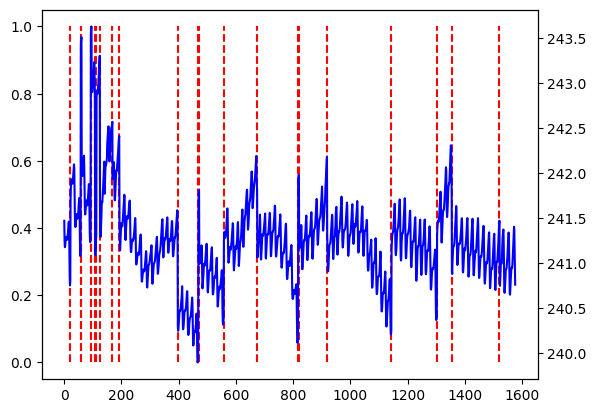

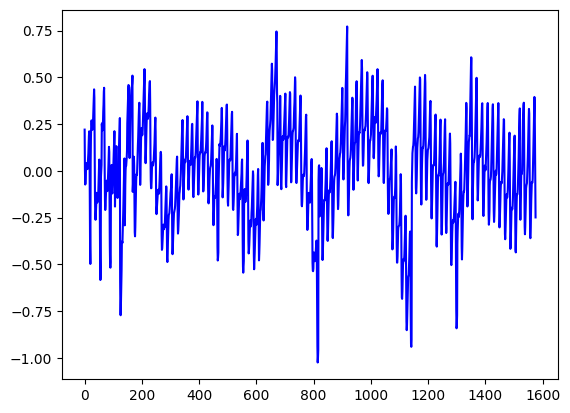

In [3]:
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import numpy as np
import pandas as pd
import math
import cv2
import os
from datetime import datetime
from numpy import pi
from scipy.signal import savgol_filter
from moviepy.editor import *

def Leer_Archivo_ExcelCalc():
    dataset = pd.read_csv('test8.csv', nrows=1, header=None)
    return np.array(dataset)
    
def Make_Plot(tiempo):
    vector= obj.Vector()
    tamMuestra = len(vector)
    distancia = tiempo/tamMuestra
    x = []

    for i in range(tamMuestra):
        x.append(i * distancia)
        
    plt.plot(x ,vector, label='Señal PPG')
    plt.xlabel('Segundos')
    plt.ylabel('Pixel')
    plt.show()

def Leer_Archivo():
    with open("glucosa/xt7pmñ66fx.bin", "r") as f: 
        chunk = f.read()
        p = chunk.split(',')
        arr = np.array(p[:len(p)-1], dtype=np.float32)
        print(len(arr))
    return arr
        
def Leer_Video(video):
    redPixels =[]
    video = cv2.VideoCapture(video)
    while (video.isOpened()):
        ret, frame = video.read()
        if ret:
            p = np.mean( frame[:,2:] )
            redPixels.append(p)
        else:
            break
    video.release()
    cv2.destroyAllWindows()
    return np.around(redPixels, decimals=3)
    
redPixels = Leer_Archivo()
ventana, diff, outlayers, sin_ma = limpiezaSenal(redPixels).Senal_1()

## La señal pasa por distintos procesos y filtros para poder obtener una señal de calidad, y así dividirla.

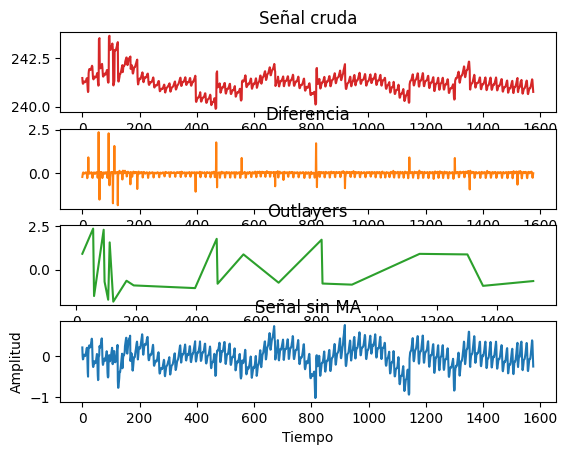

In [4]:
limpiezaSenal(redPixels).Senal_2(ventana, diff, outlayers, sin_ma)

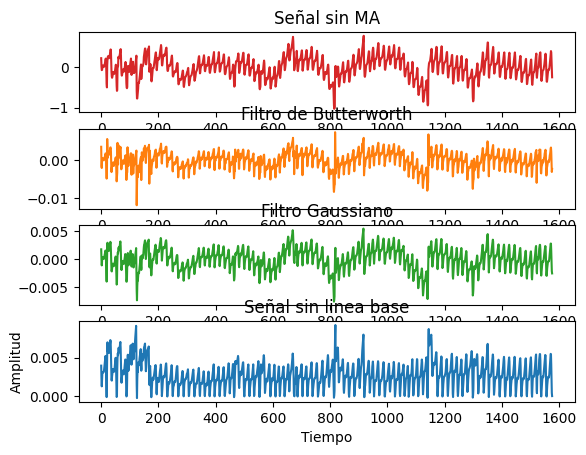

In [5]:
als = limpiezaSenal(redPixels).Senal_3(sin_ma)

## Una vez separadas las ondas, se estima la frecuencia cardiaca.
## En este ejemplo se dio una frecuencia de 93.4 bpm.

No handles with labels found to put in legend.


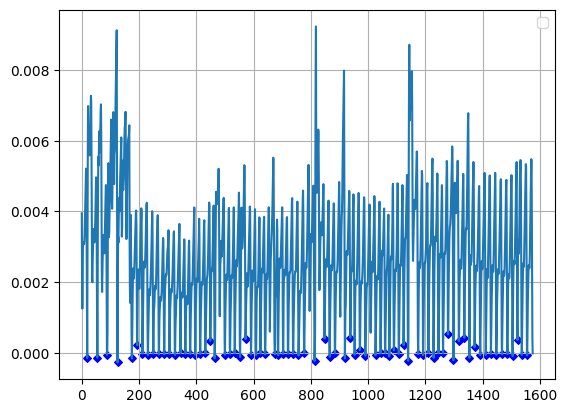

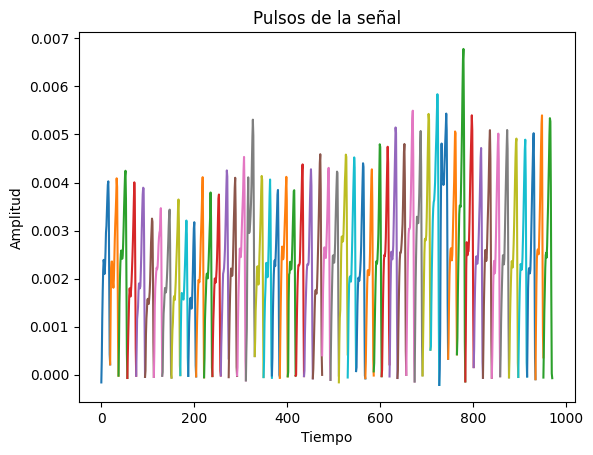

La frecuencia cardiaca es de 93.4 bpm


In [6]:
senal_limpia = limpiezaSenal(redPixels).Senal_4(als)
signos = VitalSigns(senal_limpia).Compute()
print(f'La frecuencia cardiaca es de %.01f ' %signos + 'bpm')